In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, time, json, re
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import data_preprocessing as dp
import backtrader as bt
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get data

In [2]:
frequency = timedelta(seconds=60)
pair = 'USDT_BTC'
date_start = '2020-11-11'
date_end = '2021-03-31'
lob_depth = 100
norm_type = 'dyn_z_score'
roll = 1440*10 # 10 days

In [ ]:
df_data, df_data_stdz = dp.import_data(
    pair, 
    date_start, 
    date_end, 
    frequency=frequency, 
    depth=lob_depth, 
    norm_type=norm_type, 
    roll=roll, 
    stdz_depth=1
)

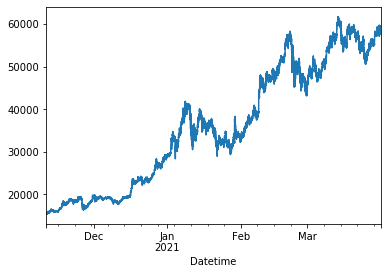

In [4]:
df_data['Mid_Price'].plot()

## Resample

In [5]:
df_data[['Mid_Price']].head(31)

,Mid_Price
Datetime,
2020-11-11 00:00:00,15301.044126
2020-11-11 00:01:00,15312.483921
2020-11-11 00:02:00,15310.754885
2020-11-11 00:03:00,15298.146251
2020-11-11 00:04:00,15286.270444
2020-11-11 00:05:00,15277.536121
2020-11-11 00:06:00,15279.773140
2020-11-11 00:07:00,15282.208578
2020-11-11 00:08:00,15278.260534


In [6]:
# resample data to a less granular frequency
df_data = df_data.asfreq('1min')
df_data['volume'] = df_data['amount_buy'] + df_data['amount_sell']

data_resampled = df_data.resample('30min', label='right').agg( # closing time of candlestick
    {
    'Mid_Price': ['last', 'first', np.max, np.min], 
    'volume': np.sum
    }
)

data_resampled.columns = data_resampled.columns.get_level_values(1)

data_resampled['close'] = data_resampled['last']
data_resampled['open'] = data_resampled['first']
data_resampled['high'] = data_resampled['amax']
data_resampled['low'] = data_resampled['amin']
data_resampled['volume'] = data_resampled['sum']
data_resampled.index.name = 'datetime'

data_resampled
# rename columns

,last,first,amax,amin,sum,close,open,high,low,volume
datetime,,,,,,,,,,
2020-11-11 00:30:00,15376.814859,15301.044126,15380.535051,15277.536121,35.609581,15376.814859,15301.044126,15380.535051,15277.536121,35.609581
2020-11-11 01:00:00,15467.419284,15394.964796,15480.689236,15394.846947,55.495822,15467.419284,15394.964796,15480.689236,15394.846947,55.495822
2020-11-11 01:30:00,15462.135463,15486.839762,15486.839762,15420.987418,29.442167,15462.135463,15486.839762,15486.839762,15420.987418,29.442167
2020-11-11 02:00:00,15434.253590,15462.297474,15470.993326,15419.815075,25.391770,15434.253590,15462.297474,15470.993326,15419.815075,25.391770
2020-11-11 02:30:00,15420.127134,15429.655957,15438.356256,15412.486304,13.592964,15420.127134,15429.655957,15438.356256,15412.486304,13.592964
...,...,...,...,...,...,...,...,...,...,...
2021-03-31 22:00:00,58951.153377,58911.054781,59210.411851,58765.664324,9.786151,58951.153377,58911.054781,59210.411851,58765.664324,9.786151
2021-03-31 22:30:00,58746.642078,58976.106069,58976.106069,58630.303175,4.856379,58746.642078,58976.106069,58976.106069,58630.303175,4.856379
2021-03-31 23:00:00,58633.142900,58723.780340,58805.209845,58621.977813,9.605532,58633.142900,58723.780340,58805.209845,58621.977813,9.605532


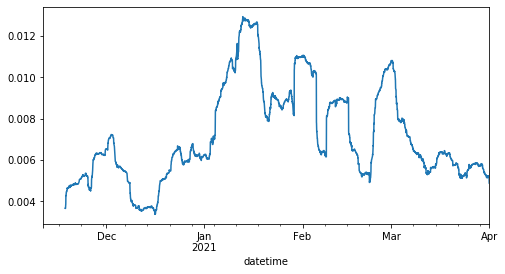

In [7]:
data_resampled['log_ret'] = (np.log(data_resampled['close']) - np.log(data_resampled['close'].shift(1)))
data_resampled['roll_std'] = data_resampled['log_ret'].rolling(window=336).std() # 336 is the number of 30mins interval in week
data_resampled['roll_std'].plot(figsize=(8,4))

## Backtrader

In [ ]:
from Strategies.GoldenCross import GoldenCross
from Strategies.BuyHold import BuyHold

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(GoldenCross)

# Create a Data Feed
data = bt.feeds.PandasData(dataname=data_resampled[:2000])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

cerebro.addwriter(bt.WriterFile, out='./Strategies/logging/golden_cross2.csv', csv=True)

# Set our desired cash start
cerebro.broker.setcash(200000.0)
# Add a FixedSize sizer according to the stake
# cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
# cerebro.broker.setcommission(commission=0.0007) 

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything


cerebro.run()

plt.rcParams['figure.figsize']=[22, 16]
cerebro.plot()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# figure out what's wrong with stop losses


In [ ]:
strategy_results = pd.read_csv('./Strategies/logging/golden_cross2.csv', header=1, index_col='Id').dropna(thresh=3)
strategy_results['datetime'] = pd.to_datetime(strategy_results['datetime'])
print(strategy_results.shape)

In [ ]:
strategy_and_indic = pd.merge(data_resampled, strategy_results, left_index=True, right_on='datetime', how='outer')
print(strategy_and_indic.columns)
columns_to_keep = ['datetime', 'open_x', 'close_x', 'high_x', 'low_x', 'cash', 'value', 'buy', 'sell', 'pnlplus', 'pnlminus', 'sma', 'sma.1', 'crossover']
strategy_and_indic[columns_to_keep].to_csv('./Strategies/logging/golden_cross_cl.csv')

In [ ]:
# def saveplots(cerebro, numfigs=1, iplot=True, start=None, end=None,
#              width=16, height=9, dpi=300, tight=True, use=None, file_path = '', **kwargs):

#         from backtrader import plot
#         if cerebro.p.oldsync:
#             plotter = plot.Plot_OldSync(**kwargs)
#         else:
#             plotter = plot.Plot(**kwargs)

#         figs = []
#         for stratlist in cerebro.runstrats:
#             for si, strat in enumerate(stratlist):
#                 rfig = plotter.plot(strat, figid=si * 100,
#                                     numfigs=numfigs, iplot=iplot,
#                                     start=start, end=end, use=use)
#                 figs.append(rfig)

#         for fig in figs:
#             for f in fig:
#                 f.savefig(file_path, bbox_inches='tight')
#         # return figs

# saveplots(cerebro, file_path = 'savefig.png') 

## My trading functions

In [8]:
## Roadmap
# for each trade I need entry price, closing price, number of periods, time in the trade, min, max, volatility V 
# make execution assumptions: conservative: enter trade next open bar, exit trade next open bar V
# add stops and trailing stops
# pull more data
# add single strategy to binance account with cctx
# backtest multiple strategies across multiple pairs
# deploy multiple strategies

In [9]:
import ccxt
import ta
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import EMAIndicator
import config
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
## Exchange connectivity
exchange = ccxt.binance(
    {
        'apiKey': config.BINANCE_API_KEY,
        'secret': config.BINANCE_SECRET_KEY
    }
)

markets = exchange.load_markets()

bars = exchange.fetch_ohlcv('ETH/USDT', limit=20) # most recent candle keeps evolving

In [109]:
from StratTest.engine import TradingStrategy

In [110]:
trading_strategy = TradingStrategy(data_resampled[['open', 'high', 'low', 'close', 'volume']].copy())

trading_strategy.add_indicator('BollingerBands', window=20)
trading_strategy.add_indicator('EMAIndicator', window=20)
trading_strategy.add_indicator('EMAIndicator', window=50)

In [116]:
# df =data_resampled[['open', 'high', 'low', 'close', 'volume']].copy() # pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# ## Create Indicators
# # Bollinger Bands
# bb_indicator = BollingerBands(df['close'], window=20)

# df['upper_band'] = bb_indicator.bollinger_hband()
# df['lower_band'] = bb_indicator.bollinger_lband()
# df['moving_average'] = bb_indicator.bollinger_mavg()

# # Average True Range
# atr_indicator = AverageTrueRange(df['high'], df['low'], df['close'])
# df['atr'] = atr_indicator.average_true_range()

# # Moving Averages
# ema50_indicator = EMAIndicator(df['close'], 50)
# df['ema_50'] = ema50_indicator.ema_indicator()

# ema20_indicator = EMAIndicator(df['close'], 20)
# df['ema_20'] = ema20_indicator.ema_indicator()

In [69]:
## Generate Signals
# EMA cross
df['ema_cross_signal'] = np.where(
    df['ema_20'] > df['ema_50'], 1, 
    np.where(df['ema_20'] < df['ema_50'], -1, 0))

df['ema_cross_trades'] = np.where(
    df['ema_cross_signal'].diff() > 0, 'buy', 
    np.where(df['ema_cross_signal'].diff() < 0, 'sell', 'hold'))

df['ema_cross_new_position'] = np.where(
    df['ema_cross_signal'].diff() > 0, +1, 
    np.where(df['ema_cross_signal'].diff() < 0, -1, 0))

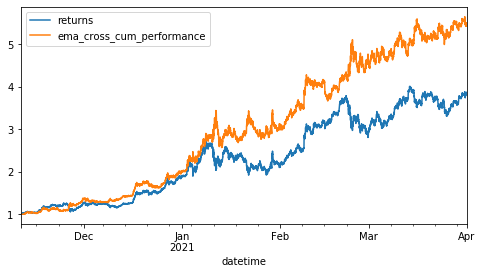

In [70]:
## Backtesting
initial_cash = 1000

df['returns'] = np.log(df['close']) - np.log(df['close'].shift(1))
df['ema_cross_returns'] = df['returns'] * df['ema_cross_signal']

df['ema_cross_cum_performance'] = np.exp(df['ema_cross_returns'].cumsum())
df['ema_cross_cash'] = df['ema_cross_cum_performance'] * initial_cash

np.exp(df['returns'].cumsum()).plot(figsize=(8,4), legend=True) # reverse log returns to prices
df['ema_cross_cum_performance'].plot(legend=True)

In [87]:
# potential entry points

df['potential_entry_price'] = df['open'].shift(-1) # assume entry trade is executed at the next bar open
df['potential_closing_price'] = df['open'].shift(-1) # assume closing is executed at the next bar open
df[['open', 'potential_entry_price']]

# get positions in the dataframe where indicator generates signals
open_trades_idx = np.where(df['ema_cross_new_position']!=0)[0]
# -2 because of shape is n rows and df is 0 indexed and because we do + 1 later - avoid out of bound error
closing_trades_idx = np.append(open_trades_idx, df.shape[0]-2)[1:] 

df['trade_grouper'] = np.nan
df.loc[df.iloc[open_trades_idx].index, 'trade_grouper'] = df.iloc[open_trades_idx].index
df['trade_grouper'] = df['trade_grouper'].fillna(method='ffill')

# scenario where no stop loss is present, invested position is the same as the signal output
df['strategy_new_position'] = df['ema_cross_new_position'].copy()
df['strategy_trades'] = df['ema_cross_trades'].copy()
df['strategy_signal'] = df['ema_cross_signal'].copy()

# col to keep track of stop loss trigger
df['sl_trigger'] = np.nan
df['sl_hit'] = np.nan

all_trades_list = []
for name, sub_df in df.groupby(by='trade_grouper'):

    entry_price = df[df.index==name]['potential_entry_price'].values[0]
    direction = df[df.index==name]['ema_cross_new_position'].values[0]
    print(direction)

    # check for stop losses before any backtesting
    if direction > 0:

        sl_price = entry_price * 0.99
        sub_df['sl_trigger'] = sl_price
        df.loc[sub_df.index, 'sl_trigger'] = sl_price

        if (sub_df['sl_trigger'] < sub_df['low']).sum() == sub_df.shape[0]:
            print('Long position held until signal reversed')
        else:
            sl_trigger_time = sub_df[~(sub_df['sl_trigger'] < sub_df['low'])].index[0] # when stop loss was triggered
            sl_affected_range = sub_df[sub_df.index>=sl_trigger_time].index # all the datapoints subsequently affected by stop loss

            df.loc[sl_trigger_time, 'strategy_new_position'] = -1 # create exit point when sl is hit
            df.loc[sl_trigger_time, 'strategy_trades'] = "sell" # create exit point when sl is hit
            df.loc[sl_trigger_time, 'sl_hit'] = True # flag stop loss being hit
            df.loc[sl_affected_range, 'strategy_signal'] = 0 # turn signal to 0 - out of market
            
            print('Stop loss triggered - closing long position')

    elif direction < 0:

        sl_price = entry_price * 1.01
        sub_df['sl_trigger'] =  sl_price
        df.loc[sub_df.index, 'sl_trigger'] = sl_price

        if (sub_df['sl_trigger'] > sub_df['high']).sum() == sub_df.shape[0]:
            print('Short position held until signal reversed')
        else:
            sl_trigger_time = sub_df[~(sub_df['sl_trigger'] > sub_df['high'])].index[0] # when stop loss was triggered
            sl_affected_range = sub_df[sub_df.index>=sl_trigger_time].index  # all the datapoints subsequently affected by stop loss

            df.loc[sl_trigger_time, 'strategy_new_position'] = 1 # create exit point when sl is hit
            df.loc[sl_trigger_time, 'strategy_trades'] = "buy" # create exit point when sl is hit
            df.loc[sl_trigger_time, 'sl_hit'] = True # flag stop loss being hit
            df.loc[sl_affected_range, 'strategy_signal'] = 0 # turn signal to 0 - out of market
            
            print('Stop loss triggered - closing short position')

1
Long position held until signal reversed
-1
Short position held until signal reversed
1
Long position held until signal reversed
-1
Stop loss triggered - closing short position
1
Long position held until signal reversed
-1
Stop loss triggered - closing short position
1
Stop loss triggered - closing long position
-1
Short position held until signal reversed
1
Stop loss triggered - closing long position
-1
Stop loss triggered - closing short position
1
Stop loss triggered - closing long position
-1
Stop loss triggered - closing short position
1
Stop loss triggered - closing long position
-1
Short position held until signal reversed
1
Long position held until signal reversed
-1
Stop loss triggered - closing short position
1
Stop loss triggered - closing long position
-1
Stop loss triggered - closing short position
1
Stop loss triggered - closing long position
-1
Short position held until signal reversed
1
Long position held until signal reversed
-1
Short position held until signal rever

In [88]:
df[df.index>='2020-11-22 21:00:00'].head(50)[['trade_grouper', 'trade_grouper', 'close', 'low', 'high', 'sl_trigger', 'ema_cross_new_position', 'ema_cross_signal', 'ema_cross_trades', 'strategy_new_position', 'strategy_signal', 'strategy_trades', 'sl_hit']]

,trade_grouper,trade_grouper,close,low,high,sl_trigger,ema_cross_new_position,ema_cross_signal,ema_cross_trades,strategy_new_position,strategy_signal,strategy_trades,sl_hit
datetime,,,,,,,,,,,,,
2020-11-22 21:00:00,2020-11-22 02:30:00,2020-11-22 02:30:00,18557.058459,18515.569357,18621.689252,18678.573532,0,-1,hold,0,-1,hold,NaN
2020-11-22 21:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18592.163633,18509.762467,18594.276201,18408.789719,1,1,buy,1,1,buy,NaN
2020-11-22 22:00:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18572.956162,18567.108945,18607.013325,18408.789719,0,1,hold,0,1,hold,NaN
2020-11-22 22:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18623.577580,18540.175533,18636.334640,18408.789719,0,1,hold,0,1,hold,NaN
2020-11-22 23:00:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18611.502397,18579.387884,18642.560574,18408.789719,0,1,hold,0,1,hold,NaN
2020-11-22 23:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18479.098851,18389.004645,18610.883454,18408.789719,0,1,hold,-1,0,sell,True
2020-11-23 00:00:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18417.403771,18393.887255,18527.785093,18408.789719,0,1,hold,0,0,hold,NaN
2020-11-23 00:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18257.439788,18257.439788,18504.661883,18408.789719,0,1,hold,0,0,hold,NaN
2020-11-23 01:00:00,2020-11-23 01:00:00,2020-11-23 01:00:00,18117.007445,18117.007445,18307.663346,18291.373376,-1,-1,sell,1,0,buy,True


In [51]:
df.loc[df.iloc[open_trades_idx].index, ['trade_grouper', 'ema_cross_position']].head(20)

,trade_grouper,ema_cross_position
datetime,,
2020-11-12 01:00:00,2020-11-12 01:00:00,1
2020-11-14 06:00:00,2020-11-14 06:00:00,-1
2020-11-15 09:00:00,2020-11-15 09:00:00,1
2020-11-15 18:00:00,2020-11-15 18:00:00,-1
2020-11-16 05:30:00,2020-11-16 05:30:00,1
2020-11-19 09:00:00,2020-11-19 09:00:00,-1
2020-11-19 14:00:00,2020-11-19 14:00:00,1
2020-11-22 02:30:00,2020-11-22 02:30:00,-1
2020-11-22 21:30:00,2020-11-22 21:30:00,1


In [40]:
# get positions in the dataframe where indicator generates signals
open_trades_idx = np.where(df['strategy_position']!=0)[0]
df.loc[df.iloc[open_trades_idx].index, 'trade_grouper'].head(20)

datetime
2020-11-12 01:00:00    2020-11-12 01:00:00
2020-11-14 06:00:00    2020-11-14 06:00:00
2020-11-15 09:00:00    2020-11-15 09:00:00
2020-11-15 18:00:00    2020-11-15 18:00:00
2020-11-16 04:30:00    2020-11-15 18:00:00
2020-11-16 05:00:00    2020-11-15 18:00:00
2020-11-16 05:30:00    2020-11-16 05:30:00
2020-11-19 09:00:00    2020-11-19 09:00:00
2020-11-19 11:30:00    2020-11-19 09:00:00
2020-11-19 12:00:00    2020-11-19 09:00:00
2020-11-19 12:30:00    2020-11-19 09:00:00
2020-11-19 13:00:00    2020-11-19 09:00:00
2020-11-19 13:30:00    2020-11-19 09:00:00
2020-11-19 14:00:00    2020-11-19 14:00:00
2020-11-19 23:30:00    2020-11-19 14:00:00
2020-11-22 02:30:00    2020-11-22 02:30:00
2020-11-22 21:30:00    2020-11-22 21:30:00
2020-11-22 23:30:00    2020-11-22 21:30:00
2020-11-23 01:00:00    2020-11-23 01:00:00
2020-11-23 02:30:00    2020-11-23 01:00:00
Name: trade_grouper, dtype: object

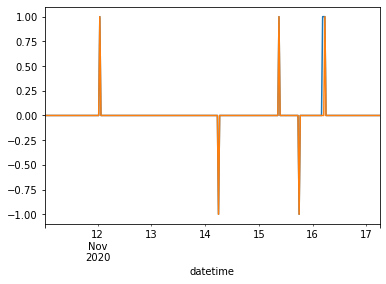

In [36]:
df['strategy_position'][:300].plot()
df['ema_cross_position'][:300].plot()

In [37]:
df_trades

NameError: name 'df_trades' is not defined

In [472]:
# prepare df trades

# get positions in the dataframe where indicator generates signals
open_trades_idx = np.where(df['ema_cross_position']!=0)[0]
# -2 because of shape is n rows and df is 0 indexed and because we do + 1 later - avoid out of bound error
closing_trades_idx = np.append(open_trades_idx, df.shape[0]-2)[1:] 
df_trades = df.iloc[open_trades_idx][['ema_cross_position']].copy() # empty dataframe with only datetime index

# entry and closing points
df_trades['entry_price'] = df.iloc[open_trades_idx+1]['open'].values # assume entry trade is executed at the next bar open
df_trades['closing_price'] = df.iloc[closing_trades_idx+1]['open'].values # assume closing is executed at the next bar open

# trade discrete returns
df_trades['discrete_return'] = df_trades['ema_cross_position'] * ((df_trades['closing_price'] / df_trades['entry_price']) - 1)

# how long are the trades 
df_trades['trade_n_periods'] = closing_trades_idx - open_trades_idx
df_trades['trade_duration'] = df.iloc[closing_trades_idx].index - df.iloc[open_trades_idx].index

# what happened throughout the trade
df['trade_grouper'] = np.nan
df.loc[df.iloc[open_trades_idx].index, 'trade_grouper'] = df.iloc[open_trades_idx].index
df['trade_grouper'] = df['trade_grouper'].fillna(method='ffill')
df.head(60)

all_trades_list = []
for name, sub_df in df.groupby(by='trade_grouper'):
    max_val = sub_df['high'].max()
    min_val = sub_df['low'].min()
    returns_std = sub_df['returns'].std()

    all_trades_list.append([name, max_val, min_val, returns_std])


intra_trade_stats = pd.DataFrame(all_trades_list, columns=['datetime', 'px_high', 'px_low', 'returns_std']).set_index('datetime')
df_trades = pd.merge(df_trades, intra_trade_stats, left_index=True, right_index=True)


def max_dd_pctg(row):
    ''' Measure of how "painful" holding the trade was '''
    if row['ema_cross_position'] == 1:
        return (row['entry_price'] - row['px_low'])/row['px_low']
    elif row['ema_cross_position'] == -1:
        return (-(row['entry_price'] - row['px_high']))/row['px_high']
    else:
        return 0

df_trades['dd_pctg'] = df_trades.apply(max_dd_pctg, axis=1)

# calculate trade returns and jump into risk management / stop losses


In [584]:
df

,open,high,low,close,volume,upper_band,lower_band,moving_average,atr,ema_50,...,ema_cross_signal,ema_cross_position,returns,ema_cross_returns,ema_cross_cash,ema_cross_cum_performance,trade_grouper,potential_entry_price,potential_closing_price,strategy_position
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-11 00:30:00,15301.044126,15380.535051,15277.536121,15376.814859,35.609581,NaN,NaN,NaN,0.000000,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,15394.964796,15394.964796,NaN
2020-11-11 01:00:00,15394.964796,15480.689236,15394.846947,15467.419284,55.495822,NaN,NaN,NaN,0.000000,NaN,...,0,0,0.005875,0.000000,1000.000000,1.000000,NaN,15486.839762,15486.839762,NaN
2020-11-11 01:30:00,15486.839762,15486.839762,15420.987418,15462.135463,29.442167,NaN,NaN,NaN,0.000000,NaN,...,0,0,-0.000342,-0.000000,1000.000000,1.000000,NaN,15462.297474,15462.297474,NaN
2020-11-11 02:00:00,15462.297474,15470.993326,15419.815075,15434.253590,25.391770,NaN,NaN,NaN,0.000000,NaN,...,0,0,-0.001805,-0.000000,1000.000000,1.000000,NaN,15429.655957,15429.655957,NaN
2020-11-11 02:30:00,15429.655957,15438.356256,15412.486304,15420.127134,13.592964,NaN,NaN,NaN,0.000000,NaN,...,0,0,-0.000916,-0.000000,1000.000000,1.000000,NaN,15411.617144,15411.617144,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 22:00:00,58911.054781,59210.411851,58765.664324,58951.153377,9.786151,59656.554958,58128.558014,58892.556486,362.469575,58692.369949,...,1,0,0.001042,0.001042,5452.917411,5.452917,2021-03-31 15:30:00,58976.106069,58976.106069,NaN
2021-03-31 22:30:00,58976.106069,58976.106069,58630.303175,58746.642078,4.856379,59605.918835,58241.657140,58923.787988,361.279097,58694.498268,...,1,0,-0.003475,-0.003475,5434.000339,5.434000,2021-03-31 15:30:00,58723.780340,58723.780340,NaN
2021-03-31 23:00:00,58723.780340,58805.209845,58621.977813,58633.142900,9.605532,59553.042445,58340.470535,58946.756490,348.561450,58692.092175,...,1,0,-0.001934,-0.001934,5423.501789,5.423502,2021-03-31 15:30:00,58635.942401,58635.942401,NaN


In [580]:
sl_trigger_time

DatetimeIndex(['2021-03-31 20:30:00'], dtype='datetime64[ns]', name='datetime', freq='30T')

In [553]:

sl_trigger_time = sub_df[~(sub_df['sl_trigger'] < sub_df['low'])].index

# shortened trade time due to stop loss
stopped_sub_df = sub_df[sub_df.index<=sl_trigger_time[0]].copy()
stopped_sub_df['strategy_position'][-1] = -1

# remaining part of the trade, now position need to change to 0
quitted_sub_df = sub_df[sub_df.index>=sl_trigger_time[0]].copy()
quitted_sub_df

<ipython-input-553-499ce1dba480>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,open,high,low,close,volume,upper_band,lower_band,moving_average,atr,ema_50,...,returns,ema_cross_returns,ema_cross_cash,ema_cross_cum_performance,trade_grouper,worst_price_timestamp,cumulative_performance,worst_period_potential_loss,sl_trigger,strategy_position
datetime,,,,,,,,,,,,,,,,,,,,,
2021-03-31 20:30:00,58548.990331,58873.512281,58447.390928,58873.512281,21.177475,59781.853585,57695.217036,58738.535311,384.620469,58662.565963,...,0.003776,0.003776,5445.735695,5.445736,2021-03-31 15:30:00,58447.390928,0.004305,-0.010864,58498.445166,0
2021-03-31 21:00:00,58908.414397,59055.207435,58861.451383,58936.783857,4.818489,59736.940621,57860.331576,58798.636099,370.987297,58673.319606,...,0.001074,0.001074,5451.588246,5.451588,2021-03-31 15:30:00,58861.451383,0.005379,-0.003857,58498.445166,0
2021-03-31 21:30:00,59001.566209,59034.233930,58871.101767,58889.757336,6.887779,59698.883021,57992.787409,58845.835215,356.140501,58681.807360,...,-0.000798,-0.000798,5447.238344,5.447238,2021-03-31 15:30:00,58871.101767,0.004581,-0.003693,58498.445166,0
2021-03-31 22:00:00,58911.054781,59210.411851,58765.664324,58951.153377,9.786151,59656.554958,58128.558014,58892.556486,362.469575,58692.369949,...,0.001042,0.001042,5452.917411,5.452917,2021-03-31 15:30:00,58765.664324,0.005623,-0.005478,58498.445166,0
2021-03-31 22:30:00,58976.106069,58976.106069,58630.303175,58746.642078,4.856379,59605.918835,58241.657140,58923.787988,361.279097,58694.498268,...,-0.003475,-0.003475,5434.000339,5.434000,2021-03-31 15:30:00,58630.303175,0.002148,-0.007768,58498.445166,0
2021-03-31 23:00:00,58723.780340,58805.209845,58621.977813,58633.142900,9.605532,59553.042445,58340.470535,58946.756490,348.561450,58692.092175,...,-0.001934,-0.001934,5423.501789,5.423502,2021-03-31 15:30:00,58621.977813,0.000214,-0.007909,58498.445166,0
2021-03-31 23:30:00,58635.942401,58848.199329,58589.546090,58792.979306,11.041039,59533.557630,58392.371368,58962.964499,342.139435,58696.048533,...,0.002722,0.002722,5438.286482,5.438286,2021-03-31 15:30:00,58589.546090,0.002936,-0.008458,58498.445166,0
2021-04-01 00:00:00,58797.627309,58857.579728,58675.941803,58749.641520,5.532347,59523.178191,58420.347504,58971.762848,330.675041,58698.150219,...,-0.000737,-0.000737,5434.277784,5.434278,2021-03-31 15:30:00,58675.941803,0.002199,-0.006996,58498.445166,0


In [564]:
sub_df.loc[sl_trigger_time, 'strategy_position'] = -1
sub_df


,open,high,low,close,volume,upper_band,lower_band,moving_average,atr,ema_50,...,returns,ema_cross_returns,ema_cross_cash,ema_cross_cum_performance,trade_grouper,worst_price_timestamp,cumulative_performance,worst_period_potential_loss,sl_trigger,strategy_position
datetime,,,,,,,,,,,,,,,,,,,,,
2021-03-31 15:30:00,58643.917833,59375.393156,58643.917833,59102.914680,42.239731,59571.187121,57216.224409,58393.705765,381.587972,58429.668960,...,0.008194,0.008194,5466.955166,5.466955,2021-03-31 15:30:00,58643.917833,0.008194,-0.007538,58498.445166,1
2021-03-31 16:00:00,59089.338552,59329.839519,58919.668336,59327.406258,45.123576,59665.511147,57184.879594,58425.195371,383.629630,58464.874344,...,0.003791,0.003791,5487.720393,5.487720,2021-03-31 15:30:00,58919.668336,0.011985,-0.002871,58498.445166,0
2021-03-31 16:30:00,59472.980979,59491.377040,59125.017817,59318.036475,51.334290,59657.689097,57188.744475,58423.216786,382.396030,58498.331683,...,-0.000158,-0.000158,5486.853698,5.486854,2021-03-31 15:30:00,59125.017817,0.011827,0.000604,58498.445166,0
2021-03-31 17:00:00,59365.926027,59365.926027,58816.273544,58983.338824,21.858685,59509.318328,57265.958297,58387.638312,394.342919,58517.351570,...,-0.005658,-0.005658,5455.894530,5.455895,2021-03-31 15:30:00,58816.273544,0.006169,-0.004621,58498.445166,0
2021-03-31 17:30:00,59011.368629,59133.047574,58942.040386,58942.040386,7.253289,59426.602909,57305.792825,58366.197867,379.818938,58534.006034,...,-0.000700,-0.000700,5452.074470,5.452074,2021-03-31 15:30:00,58942.040386,0.005468,-0.002493,58498.445166,0
2021-03-31 18:00:00,58959.684122,59235.246928,58959.684122,59231.869414,12.410086,59539.160280,57294.098803,58416.629542,373.632339,58561.373225,...,0.004905,0.004905,5478.883339,5.478883,2021-03-31 15:30:00,58959.684122,0.010374,-0.002194,58498.445166,0
2021-03-31 18:30:00,59279.890464,59408.488562,59190.622895,59327.239768,10.512199,59641.899295,57347.930206,58494.914751,362.506148,58591.407207,...,0.001609,0.001609,5487.704992,5.487705,2021-03-31 15:30:00,59190.622895,0.011982,0.001714,58498.445166,0
2021-03-31 19:00:00,59409.896898,59537.414072,59306.414661,59310.121219,15.532674,59734.003884,57391.178157,58562.591021,353.112809,58619.592070,...,-0.000289,-0.000289,5486.121545,5.486122,2021-03-31 15:30:00,59306.414661,0.011694,0.003674,58498.445166,0
2021-03-31 19:30:00,59364.132362,59526.696939,59328.905786,59498.312837,7.613077,59849.142859,57420.576126,58634.859492,343.360160,58654.051708,...,0.003168,0.003168,5503.529065,5.503529,2021-03-31 15:30:00,59328.905786,0.014862,0.004054,58498.445166,0


In [559]:
sub_df[sub_df.index<=sl_trigger_time[0]]['strategy_position'][-1] = -1
sub_df[sub_df.index<=sl_trigger_time[0]]['strategy_position']

/home/federico/Python_vsc_dir/RL_Trader/rltrader_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



datetime
2021-03-31 15:30:00    1
2021-03-31 16:00:00    0
2021-03-31 16:30:00    0
2021-03-31 17:00:00    0
2021-03-31 17:30:00    0
2021-03-31 18:00:00    0
2021-03-31 18:30:00    0
2021-03-31 19:00:00    0
2021-03-31 19:30:00    0
2021-03-31 20:00:00    0
2021-03-31 20:30:00    0
Freq: 30T, Name: strategy_position, dtype: int64

In [515]:
def get_worst_price(row):
    ''' Get worst price relative to position '''
    if row['ema_cross_signal'] > 0:
        return min(row['open'], row['high'], row['low'], row['close'])
    elif row['ema_cross_signal'] < 0:
        return max(row['open'], row['high'], row['low'], row['close'])
    else:
        return 0



# static stop

sub_df['worst_price_timestamp'] = sub_df.apply(get_worst_price, axis=1)
# calculate loss vs worst price over the period
sub_df['cumulative_performance'] = sub_df['ema_cross_returns'].cumsum()
sub_df['worst_period_potential_loss'] = sub_df['ema_cross_signal'] * ((sub_df['worst_price_timestamp'] / entry_price) - 1)

sub_df[['ema_cross_returns', 'cumulative_performance', 'worst_period_potential_loss']]

,ema_cross_returns,cumulative_performance,worst_period_potential_loss
datetime,,,
2021-03-31 15:30:00,0.008194,0.008194,-0.007538
2021-03-31 16:00:00,0.003791,0.011985,-0.002871
2021-03-31 16:30:00,-0.000158,0.011827,0.000604
2021-03-31 17:00:00,-0.005658,0.006169,-0.004621
2021-03-31 17:30:00,-0.000700,0.005468,-0.002493
2021-03-31 18:00:00,0.004905,0.010374,-0.002194
2021-03-31 18:30:00,0.001609,0.011982,0.001714
2021-03-31 19:00:00,-0.000289,0.011694,0.003674
2021-03-31 19:30:00,0.003168,0.014862,0.004054


In [ ]:
df_trades.apply(lambda x: (x['closing_price'] / x['entry_price']) - 1)

In [490]:
## Metrics
# Net Profit
net_profit = df['ema_cross_cash'][-1] - initial_cash 

# Max Drowdown
max_dd = df_trades['dd_pctg'].max()

# Win Ratio
win_ratio = (df_trades['discrete_return']>0).sum() / df_trades.shape[0]

print(f'Net Profit: {net_profit:.2f}, Max Drawdown: {max_dd:.2%}, Win Ratio: {win_ratio:.2%}')

Net Profit: 4434.28, Max Drawdown: 7.93%, Win Ratio: 33.33%


In [ ]:
# # df['close'].plot(legend=True)
# ((np.exp(df['ema_cross_returns'].cumsum()) * 100)).plot(legend=True)
# # ((np.exp(df['returns'].cumsum()) * df['close'][0])).plot(legend=True)

In [ ]:
# df['ema_cross_position'].cumsum().plot()
# df['ema_cross_signal'].plot()

In [491]:
## Plotting
plot_indic_list = ['ema_50', 'ema_20']
plot_indic_color = ['#CCFFFF', '#FFCCFF']

fig = make_subplots(
    rows=2, 
    cols=1,
    shared_xaxes=True,
    row_heights=[0.2, 0.8],
    vertical_spacing=0.02
)

fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='px',
        increasing_line_color= 'green', 
        decreasing_line_color= 'red'
    ),
    row=2, 
    col=1
)
# candlestick xaxes
fig.update_xaxes(rangeslider_visible=False,    row=2,
    col=1)


# add indicators to candlestick chart
for indic, color in zip (plot_indic_list, plot_indic_color):
    fig.add_scatter(
        x=df.index, 
        y=df[indic], 
        name=indic, 
        marker=dict(color=color),
        row=2, 
        col=1
    )

# add buy trades marks
fig.add_scatter(
    x=df.index, 
    y=df['close']+100, 
    showlegend=False,
    # name='trades', 
    mode='markers',
    marker=dict(
        size=12,
        # I want the color to be green if 
        # lower_limit ≤ y ≤ upper_limit
        # else red
        color=(
            (df['ema_cross_trades'] == 'buy')).astype('int'),
        colorscale=[[0, 'rgba(255, 0, 0, 0)'], [1, '#B7FFA1']],
        symbol=5
    ),
    row=2, 
    col=1
)

# add sell trades marks
fig.add_scatter(
    x=df.index, 
    y=df['close']-100, 
    showlegend=False,
    # name='trades', 
    mode='markers',
    marker=dict(
        size=12,
        # I want the color to be green if 
        # lower_limit ≤ y ≤ upper_limit
        # else red
        color=(
            (df['ema_cross_trades'] == 'sell')).astype('int'),
        colorscale=[[0, 'rgba(255, 0, 0, 0)'], [1, '#FF7F7F']],
        symbol=6   
        ),
        row=2, 
        col=1
)

# add strategy returns
fig.add_scatter(
    x=df.index,
    y=df['ema_cross_cum_performance'],
    name='cum_performance',
    row=1,
    col=1
)

# general layout
fig.update_layout(
    width=1400,
    height=600,
    title='<b>Strategy</b>',
    title_x=.5,
    yaxis_title='USDT/BTC',
    template="plotly_dark",
    # plot_bgcolor='rgb(10,10,10)'
)

fig.show()

In [82]:
df[df.index>='2020-11-22 21:00:00'].head(50)[['trade_grouper', 'trade_grouper', 'close', 'low', 'high', 'sl_trigger', 'ema_cross_new_position', 'ema_cross_signal', 'ema_cross_trades', 'strategy_new_position', 'strategy_signal', 'strategy_trades']]

,trade_grouper,trade_grouper,close,low,high,sl_trigger,ema_cross_new_position,ema_cross_signal,ema_cross_trades,strategy_new_position,strategy_signal,strategy_trades
datetime,,,,,,,,,,,,
2020-11-22 21:00:00,2020-11-22 02:30:00,2020-11-22 02:30:00,18557.058459,18515.569357,18621.689252,NaN,0,-1,hold,0,-1,hold
2020-11-22 21:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18592.163633,18509.762467,18594.276201,NaN,1,1,buy,1,1,buy
2020-11-22 22:00:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18572.956162,18567.108945,18607.013325,NaN,0,1,hold,0,1,hold
2020-11-22 22:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18623.577580,18540.175533,18636.334640,NaN,0,1,hold,0,1,hold
2020-11-22 23:00:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18611.502397,18579.387884,18642.560574,NaN,0,1,hold,0,1,hold
2020-11-22 23:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18479.098851,18389.004645,18610.883454,18408.789719,0,1,hold,-1,0,sell
2020-11-23 00:00:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18417.403771,18393.887255,18527.785093,18408.789719,0,1,hold,0,0,hold
2020-11-23 00:30:00,2020-11-22 21:30:00,2020-11-22 21:30:00,18257.439788,18257.439788,18504.661883,18408.789719,0,1,hold,0,0,hold
2020-11-23 01:00:00,2020-11-23 01:00:00,2020-11-23 01:00:00,18117.007445,18117.007445,18307.663346,18291.373376,-1,-1,sell,1,0,buy
